## Skoltech
## Intro to data science, fall 2020
## Assigment 2

### Goals
- Make exploratory data analysis
- Apply feature engineering and feature selection
- Try to solve classification task and use classification performance metrics
- Get the taste of gradient boosting approach


# Submiting the answers

Google form to submit your answers: https://docs.google.com/forms/d/1zwUO1KZNDTZYuD12dyMO3CaErGHnZuHx1Mdbo-c11ME/

Use your **skoltech email**. For Name, Surname use **exactly the same spelling** as in canvas system.

---

If your answer is a ``float number``, then it must be provided with **3 decimals after the floating point**, e.g. 1.234

---

If your answer is a ``list of float or integer numbers or str``, then they should be reported in descending (alphabetical) order,  divided by a comma, e.g.:

10.453,9.112,5.001,5.000

---

The last part (Q5) do not have corresponding fields in the google form. It is **not optional** and it will be graded manually from your .ipynb file.

---

If you have any questions regarding this Home Assignment, ask them piazza topic: https://piazza.com/class/kespugtqfrn12g?cid=29

#### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Dataset
For the task we'll use kickstarter dataset. Kickstarter is the crowdfounding platform, where people can announce their project with financial goals and other can support the projects by paying the money ("pledging"). The goal will be to predict if the project will be successfull, i.e. would it achieve the funding goal. Let's take a brief look to the dataset.

In [2]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

In [3]:
df.sample(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
524399188,Melinky - Beautiful and reliable mobile phone ...,Product Design,Design,GBP,2015-01-10,35000.0,2014-11-22 15:17:59,87.0,failed,6,GB,136.61,132.01,53107.55
1586272204,Tower 100,Video Games,Games,USD,2015-08-21,150.0,2015-07-22 20:25:31,150.0,successful,10,US,150.00,150.00,150.00
1019289383,Hondoo Outfitters LTD,Apparel,Fashion,USD,2015-03-13,3000.0,2015-02-09 18:51:55,336.0,failed,7,US,336.00,336.00,3000.00
1797154718,M-Plate: A Multi-Function Camera Tripod Plate ...,Product Design,Design,USD,2011-12-09,15000.0,2011-10-12 04:04:01,36289.0,successful,434,US,36289.00,36289.00,15000.00
1603723526,A secure SSD disk drive controlled by your sma...,Hardware,Technology,GBP,2014-07-16,131000.0,2014-06-06 09:46:02,8874.0,failed,26,GB,14858.10,15162.75,223835.97


In [4]:
df.shape

(378661, 14)

In [5]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# Section 1. Dataset acquaintance

-----

### Q1.1

#### How many NaN values are there in the dataset?

In [6]:
df.isnull().sum()

name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [7]:
3797 + 4

3801

In [9]:
df.dropna(axis=0, inplace=True)

----

----

Let us simplify the task a little bit: we are aiming to predict either project fails or not.
Thus 'success' projects will be encoded as 1, with state ['failed', 'canceled'] as 0 and we remove the rows with any other state.

### Q1.2 
#### How many '1' values are in resulting dataset (in state column)?

In [11]:
df[['state']] = df[['state']].replace('failed', 0)

In [12]:
df[['state']] = df[['state']].replace('canceled', 0)

In [13]:
df[['state']] = df[['state']].replace('successful', 1)

In [14]:
# df[['state']] = df[['state']].replace('live', 1)

In [15]:
df.drop( df[ df['state'] == 'undefined' ].index, inplace=True)

In [16]:
df.drop( df[ df['state'] == 'live' ].index, inplace=True)

In [17]:
df.drop( df[ df['state'] == 'suspended' ].index, inplace=True)

In [20]:
df.state.value_counts()

0    236368
1    133851
Name: state, dtype: int64

In [21]:
df.state.value_counts().sum()

370219

-----

------

### Q1.3
#### Which project attracted the biggest pay check? (on average)

In [22]:
k = df.drop( df[ df['backers'] == 0 ].index)

In [23]:
k['result'] = k[['usd_pledged_real', 'backers']].apply(lambda x: x[0]/x[1], axis=1)

In [24]:
k.result.max()

10000.0

In [26]:
_k = k[k['result'] == k.result.max()]
_k[['name', 'result']]

,name,result
ID,,
1459482568,Patented (9 seasons) food enhancer,10000.0
1767293256,KIRISUTOS PACHYDERM,10000.0
1974395971,21st CENTURY MEDICAL PRACTICE SYSTEM THAT CHAN...,10000.0
2024799289,The Commoner Princess,10000.0
281085395,"""SUNBURN"" - starring Michael Madsen, indie act...",10000.0
472233286,"Hollow Earth Project, Journey to the center of...",10000.0
642968820,Nobody: The Movie (Canceled),10000.0
889803741,Post Traumatic Stress (PTSD) Affects Us All,10000.0
912587650,The Hare On The Chair - An Easter Legend,10000.0


-----

-----

### Q1.4
#### What is the most successful main category (in terms of relative success)?

In [27]:
z = df[['main_category', 'state']].copy()

In [28]:
z['state'] = z['state'].apply(pd.to_numeric)

In [29]:
z.groupby(by='main_category')[['state']].mean().sort_values(by=['state'], ascending=False)

,state
main_category,
Dance,0.625803
Theater,0.602212
Comics,0.544963
Music,0.490927
Art,0.413107
Film & Video,0.379328
Games,0.360552
Design,0.357411
Publishing,0.315271


-----

-----

### Q1.5
#### How much times the most expensive (relatively) category (not main_category) met in the dataset?

In [30]:
df.groupby(by='category')[['goal']].mean().sort_values(by=['goal'], ascending=False)

,goal
category,
Movie Theaters,1.594601e+06
Space Exploration,6.245547e+05
Fantasy,6.216058e+05
Architecture,4.765797e+05
Science Fiction,4.299817e+05
...,...
Candles,5.678515e+03
Poetry,5.342948e+03
Stationery,4.213168e+03


In [31]:
df[df['category'] == 'Movie Theaters'].category.value_counts()

Movie Theaters    227
Name: category, dtype: int64

-----

-----

### Q1.6
#### What is the category with biggest total pledge? Use 'usd_pledged_real' to judge.

In [32]:
df.groupby(by='category')[['usd_pledged_real']].sum().sort_values(by=['usd_pledged_real'], ascending=False)

,usd_pledged_real
category,
Product Design,6.284380e+08
Tabletop Games,4.625848e+08
Video Games,2.157557e+08
Hardware,1.540924e+08
Documentary,1.387601e+08
...,...
Literary Spaces,1.891494e+05
Quilts,1.704812e+05
Embroidery,9.480322e+04


In [33]:
# Product Design

------

------

As one can notice, there are both numerical and object-type data in our dataframe. 

We suggest you to split them to perform EDA separately. 

### Q1.7
#### Split columns to 'numeric' (by data type) and object-type. How many 'object-type' features are there?

In [34]:
df.dtypes.value_counts()

object     8
float64    5
int64      1
dtype: int64

In [35]:
df.dtypes

name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

### Q1.8
Let's do a bit of feature engineering. Pay attention to plenged / goal ratio. How many outliers are there?
(We use a simple rule: an object is an outlier if it does not belong to [q25 - 1.5iqr, q75 + 1.5 iqr] interval, where qxx -- xx quantile, and iqr is inter-quantile range.)

In [36]:
df['pledge2goal'] = df[['pledged', 'goal']].apply(lambda x: x[0]/x[1], axis=1)

In [37]:
Q1 = df['pledge2goal'].quantile(.25)
Q3 = df['pledge2goal'].quantile(.75)
IQR = Q3 - Q1

In [38]:
Q1, Q3

(0.0048, 1.0666666666666667)

In [39]:
((df['pledge2goal'] < (Q1 - 1.5 * IQR)) | (df['pledge2goal'] > (Q3 + 1.5 * IQR))).sum()

17814

In [40]:
n = df.query('(@Q1 - 1.5 * @IQR) <= pledge2goal <= (@Q3 + 1.5 * @IQR)')
n.shape

(352405, 15)

In [37]:
n[n['goal'] == n['goal'].max()]['pledge2goal']

ID
1119122774    1.000000e-08
1168153740    0.000000e+00
1279992058    1.300000e-07
1370542565    1.150000e-06
1371612630    0.000000e+00
1395179504    2.000000e-08
1481016469    0.000000e+00
1485385229    2.270000e-06
1601563193    1.000000e-08
1654077554    1.950000e-05
1720842777    0.000000e+00
1806062709    1.000000e-08
1815288309    0.000000e+00
2000749004    0.000000e+00
2075450016    2.000000e-07
2083255961    5.600000e-07
208731425     5.900000e-07
2094346154    0.000000e+00
2132015082    3.600000e-07
2137925650    0.000000e+00
219702078     0.000000e+00
308045282     1.000000e-08
379409641     1.000000e-08
388031956     1.000000e-08
487345242     0.000000e+00
499583381     1.000000e-08
601594365     1.000000e-08
794141191     3.577000e-05
813343172     0.000000e+00
843636303     1.400000e-07
941328479     0.000000e+00
944541075     2.000000e-08
953415668     1.000000e-07
962949560     0.000000e+00
Name: pledge2goal, dtype: float64

In [41]:
n['goal'].max()

100000000.0

### Q1.9
#### Visualize the feature for success and fail cases. What can you say about received distributions? (use bins=10 or 20). Type letter as your answer
- A. Distributions intersect significantly, hard to say for sure that the ratio matters.
- B. Distributions have almost no intersection, the bigger ratio, the bigger success.
- C. Distributions have almost no intersection, the less ratio, the less success.
- D. Distributions have almost no intersection, the less ratio, the bigger success.

In [46]:
_n = n[n['state'] == 0]

In [47]:
n_ = n[n['state'] == 1]

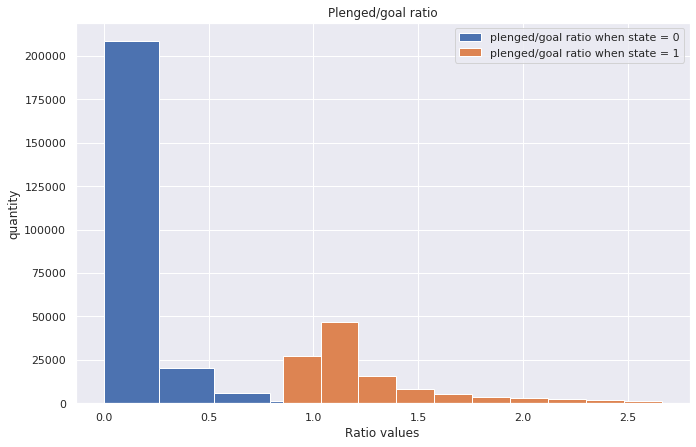

In [48]:
plt.figure(figsize=(11,7))
plt.hist(_n['pledge2goal'], bins = 10, label='plenged/goal ratio when state = 0')
plt.hist(n_['pledge2goal'], bins = 10, label='plenged/goal ratio when state = 1')
plt.title("Plenged/goal ratio")
plt.xlabel('Ratio values')
plt.ylabel('quantity')
plt.legend()
plt.show()

In [49]:
# Answer: B,C

-----

-----

### Q1.10
#### Where are the peaks located?

In [50]:
1,0

(1, 0)

-----

-----

### Q1.11
#### Compute Pearson correlation coefficiton between the ratio and target variable. (Round up to second digit after point)

In [51]:
l = n.copy()
l["state"] = l["state"].astype(bool)

In [52]:
l[['state', 'pledge2goal']].corr(method='pearson')

,state,pledge2goal
state,1.00000,0.91574
pledge2goal,0.91574,1.00000


In [53]:
round(0.915736, 2)

0.92

----

-----

### Q1.12
#### Visualize dependancy of numerical data with success. What do you think of it?

In [54]:
o = l[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'pledge2goal', 'state']].copy()

In [55]:
_o = n[n['state'] == 0]
o_ = n[n['state'] == 1]

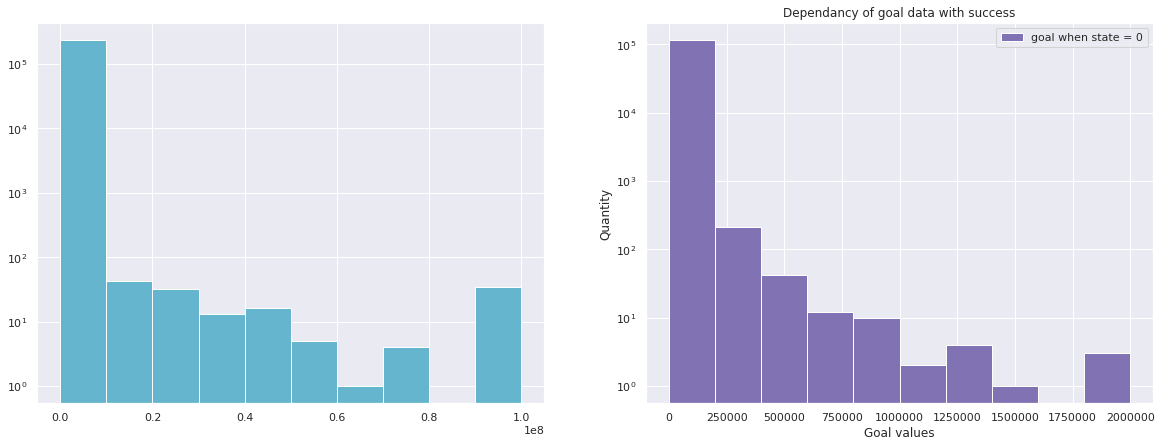

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].hist(_o['goal'], bins=10, label='goal when state = 1', log=True, color='c')
ax[1].hist(o_['goal'], bins=10, label='goal when state = 0', log=True, color='m')
plt.title("Dependancy of goal data with success")
plt.xlabel('Goal values')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
# Not a very good relationship, as the signs overlap rather poorly. To be more precise - one enters the other

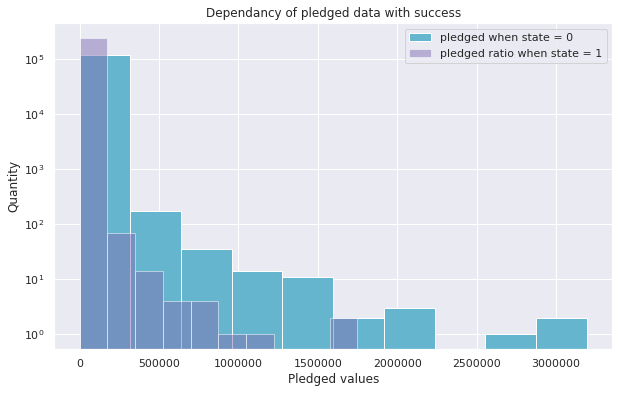

In [50]:
plt.figure(figsize=(10,6))
plt.hist(o_['pledged'], bins=10, label='pledged when state = 0', log=True, color='c')
plt.hist(_o['pledged'], bins=10, label='pledged ratio when state = 1', log=True, alpha = 0.5, color='m')
plt.title("Dependancy of pledged data with success")
plt.xlabel('Pledged values')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
# Pretty good relationship

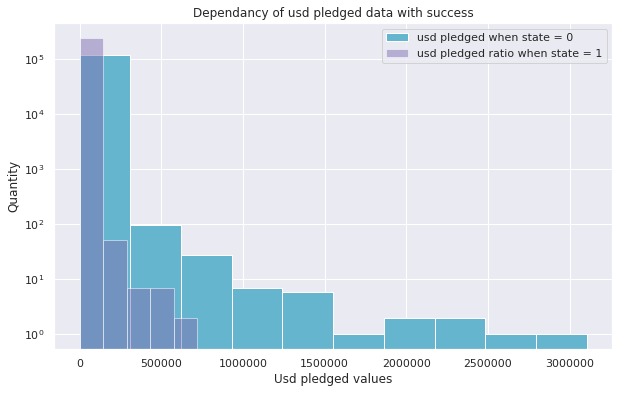

In [51]:
plt.figure(figsize=(10,6))
plt.hist(o_['usd pledged'], bins=10, label='usd pledged when state = 0', log=True, color='c')
plt.hist(_o['usd pledged'], bins=5, label='usd pledged ratio when state = 1', log=True, alpha = 0.5, color='m')
plt.title("Dependancy of usd pledged data with success")
plt.xlabel('Usd pledged values')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
# Not a very good and not a very bad addiction. 
#As you can see from the graph, there are values where the features do not intersect, this is not very good

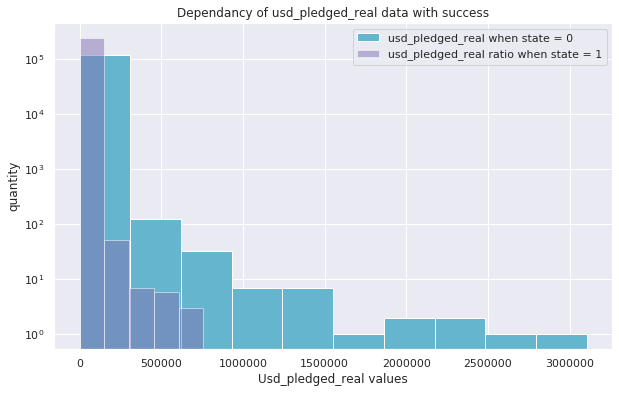

In [52]:
plt.figure(figsize=(10,6))
plt.hist(o_['usd_pledged_real'], bins=10, label='usd_pledged_real when state = 0', log=True, color='c')
plt.hist(_o['usd_pledged_real'], bins=5, label='usd_pledged_real ratio when state = 1', log=True, alpha = 0.5, color='m')
plt.title("Dependancy of usd_pledged_real data with success")
plt.xlabel('Usd_pledged_real values')
plt.ylabel('quantity')
plt.legend()
plt.show()

In [ ]:
# Not a very good and not a very bad addiction. 
#As you can see from the graph, there are values where the features do not intersect, this is not very good

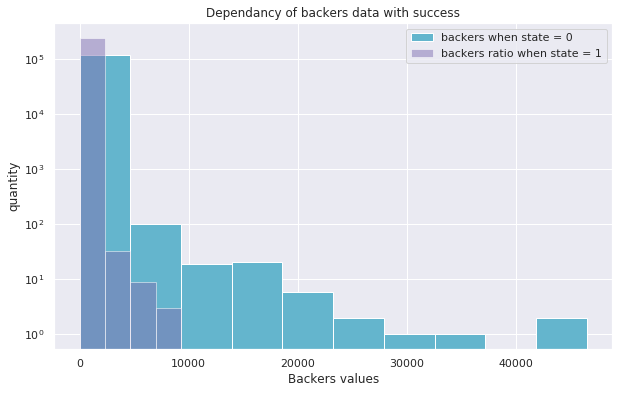

In [53]:
plt.figure(figsize=(10,6))
plt.hist(o_['backers'], bins=10, label='backers when state = 0', log=True, color='c')
plt.hist(_o['backers'], bins=4, label='backers ratio when state = 1', log=True, alpha = 0.5, color='m')
plt.title("Dependancy of backers data with success")
plt.xlabel('Backers values')
plt.ylabel('quantity')
plt.legend()
plt.show()

In [ ]:
# Not a very good and not a very bad addiction. 
#As you can see from the graph, there are values where the features do not intersect, this is not very good

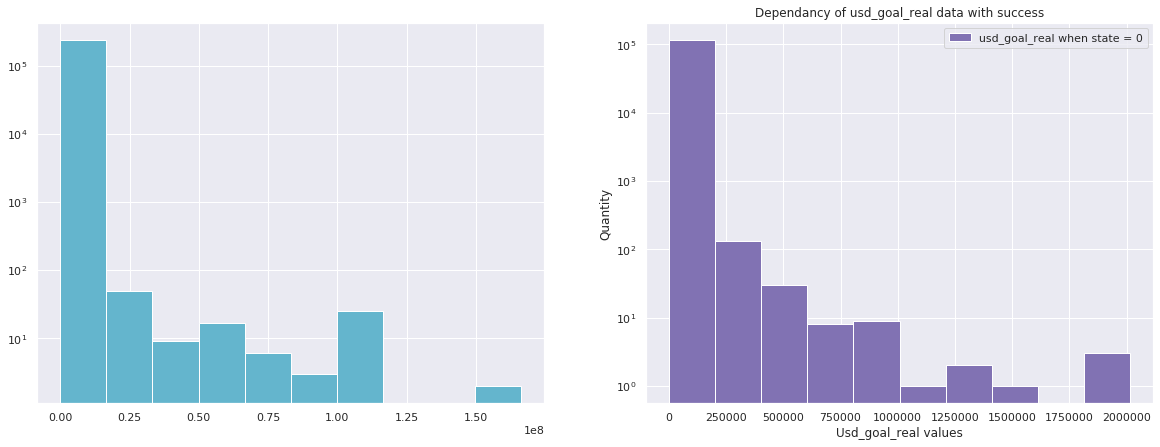

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].hist(_o['usd_goal_real'], bins=10, label='usd_goal_real when state = 1', log=True, color='c')
ax[1].hist(o_['usd_goal_real'], bins=10, label='usd_goal_real when state = 0', log=True, color='m')
plt.title("Dependancy of usd_goal_real data with success")
plt.xlabel('Usd_goal_real values')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
# Not a very good relationship, as the signs overlap rather poorly. To be more precise - one enters the other

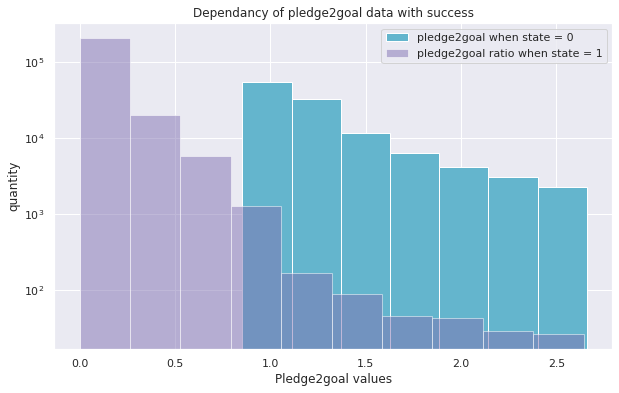

In [56]:
plt.figure(figsize=(10,6))
plt.hist(o_['pledge2goal'], bins=7, label='pledge2goal when state = 0', log=True, color='c')
plt.hist(_o['pledge2goal'], bins=10, label='pledge2goal ratio when state = 1', log=True, alpha = 0.5, color='m')
plt.title("Dependancy of pledge2goal data with success")
plt.xlabel('Pledge2goal values')
plt.ylabel('quantity')
plt.legend()
plt.show()

In [ ]:
# good but not enough. The model can be retrained

# Feature generation
Lets' generate some more feature that could be useful

### Q2.1 Create a year column that would hold the year. How many projects were in year 2012?

In [57]:
df['launched'] = pd.to_datetime(df['launched'])
df['year'] = df.launched.dt.year

In [58]:
df[df['year'] == 2012].count()

name                41109
category            41109
main_category       41109
currency            41109
deadline            41109
goal                41109
launched            41109
pledged             41109
state               41109
backers             41109
country             41109
usd pledged         41109
usd_pledged_real    41109
usd_goal_real       41109
pledge2goal         41109
year                41109
dtype: int64

### Q2.2 Make a column 'duration_days' with number of full days from launch to deadline.
What is median value for this column?

In [59]:
df['deadline'] = pd.to_datetime(df['deadline'])

In [60]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = df['deadline'] - df['launched']

In [61]:
df['duration_days'] = df['duration_days'].astype('timedelta64[D]')

In [62]:
df['duration_days'].median()

29.0

### Q2.3 Delete mistaken value from column 'country'. What is the value?

In [63]:
df['country'].value_counts()

US    289669
GB     33214
CA     14508
AU      7681
DE      4057
FR      2873
NL      2807
IT      2775
ES      2204
SE      1718
MX      1632
NZ      1425
DK      1083
IE       793
CH       736
NO       694
BE       597
AT       576
HK       564
SG       521
LU        61
JP        31
Name: country, dtype: int64

In [64]:
# Comment: Mistaken value from column 'country' is N,0 But in point 1.1 I deleted all NAS's, so I didn't have an erroneous value in the "country" column. If you return the NAN's, you can see N,0

### Q2.4 Make column 'region' out of column country (america, europe, asia, oceania(including australiza/nz))
Where is the region with the worst conversion rate (percentage of successful projects)

In [65]:
df['region'] = df[['country']].copy()

In [66]:
df['region'] = df[['region']].replace('GB', 'Europe')
df['region'] = df[['region']].replace('US', 'America')
df['region'] = df[['region']].replace('CA', 'America')
df['region'] = df[['region']].replace('AU', 'Oceania')
df['region'] = df[['region']].replace('NO', 'Europe')
df['region'] = df[['region']].replace('IT', 'Asia')
df['region'] = df[['region']].replace('DE', 'Europe')
df['region'] = df[['region']].replace('IE', 'Europe')
df['region'] = df[['region']].replace('MX', 'America')
df['region'] = df[['region']].replace('ES', 'Europe')
df['region'] = df[['region']].replace('SE', 'Europe')
df['region'] = df[['region']].replace('FR', 'Europe')
df['region'] = df[['region']].replace('NL', 'Europe')
df['region'] = df[['region']].replace('NZ', 'Oceania')
df['region'] = df[['region']].replace('CH', 'Europe')
df['region'] = df[['region']].replace('AT', 'Europe')
df['region'] = df[['region']].replace('BE', 'Europe')
df['region'] = df[['region']].replace('DK', 'Asia')
df['region'] = df[['region']].replace('HK', 'Asia')
df['region'] = df[['region']].replace('LU', 'Europe')
df['region'] = df[['region']].replace('SG', 'Asia')
df['region'] = df[['region']].replace('JP', 'Asia')

In [67]:
z = df[['region', 'state']].copy()
z['state'] = z['state'].apply(pd.to_numeric)

In [68]:
z.groupby(by='region')[['state']].mean().sort_values(by=['state'])

,state
region,
Asia,0.241255
Oceania,0.269932
Europe,0.325134
America,0.372223


### Q2.5 For each main_category leave only the three most popular category and replace other with "other"
What is the most frequent subcategory for design?

In [69]:
a = df.copy()

In [70]:
_df = a.groupby(['main_category'])['category'].apply(lambda x: x.value_counts().nlargest(3))
largest_cats = _df.to_dict()

In [71]:
def other(x):
    for key in largest_cats.keys():
        if x == key[1]:
            return x
    return 'other'

In [72]:
a['category'] = a.apply(lambda x: other(x.category), axis = 1)

In [73]:
_df = a[a['main_category'] == 'Design']

In [74]:
_df['category'].value_counts().index[0]

'Product Design'

## Q2.6 create the columns "name_length" with length of the name.
What is the biggets length?

In [75]:
df['name_length'] = df['name'].str.len()

In [76]:
df['name_length'].max()

96

# Preprocessing

### Q3.1 Drop the leaking columns
Based on what we have already seen, can you assume what features are leakeges? What is the columns? Drop them


In [77]:
# name : name of project // name: название проекта
# main_category : category of campaign // main_category: категория кампании
# currency : currency used to support // валюта: валюта, используемая для поддержки
# deadline : deadline for crowdfunding // крайний срок: крайний срок для краудфандинга
# goal : fundraising goal // цель: цель сбора средств
# launched : date launched // запущен: дата запуска
# pledged : amount pledged by crowd // заложено: сумма, заложенная толпой
# state : current condition the project is in // состояние: текущее состояние, в котором находится проект
# backers : number of backers // спонсоры: количество спонсоров
# country : country pledged from // страна: страна заложенная от
# usd pledged : amount of money pledged // usd pledged: сумма залога
# usd_pledged_real : conversion in US dollars of the pledged column // usd_pledged_real: конвертация в доллары США заложенного столбца
# usd_goal_real : conversion in US dollars of the goal column // usd_goal_real: преобразование в долларах США столбца цели

In [78]:
df = df.drop(columns=['pledge2goal'])

### Q3.2 Deal with the categorical features.
Lets drop some more columns for now (name, deadline, launched, country, usd_goal_real). Note: you can re-use these columns in the Q5 section. 
Preprocess the rest of categorical columns. How many columns do you have now?

In [79]:
df = df.drop(columns=['name', 'deadline', 'launched', 'country', 'usd_goal_real', 'name_length'])

In [80]:
# I also drop 'name_length' column because its give no infomation

In [81]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category', 'main_category', 'currency', 'region']

encoder = LabelEncoder()

df[cat_features] = df[cat_features].apply(encoder.fit_transform)

In [82]:
df.shape

(370219, 12)

### Q3.3 Split the dataset
Separate the target column (state) without stratification and with random state 42 and test size 0.2. How many of successful projects in train set?

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X = df.drop('state', axis=1, inplace=False)
Y = df[['state']]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [86]:
y_train[y_train['state'] == 1].shape

(107134, 1)

### Q3.4 Scale the numeric columns with standard scaler
What is max number in goal field after scaling?

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
X_train[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real']] = StandardScaler().fit_transform(X_train[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real']])

/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/artem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [93]:
X_test[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real']] = StandardScaler().fit_transform(X_test[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real']])

/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/artem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [94]:
X_train['goal'].max()

93.26426315218663

In [95]:
X_test['goal'].max()

68.38043436286037

# Feature selection

### Q4.1 Estimate feature importance by Anova
What is the two most important features by anova with f classifier?

In [96]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [97]:
X_train_numerical = X_train.select_dtypes(exclude=['object', 'int64'])

In [98]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train_numerical, y_train['state'].tolist())

SelectKBest(k='all', score_func=<function f_classif at 0x7f51377a8c20>)

Feature goal: 196.70351403316963
Feature pledged: 4180.7359922801
Feature backers: 4948.1779216469995
Feature usd pledged: 3346.9514116710643
Feature usd_pledged_real: 4202.167956342883
Feature duration_days: 226.80518274581678


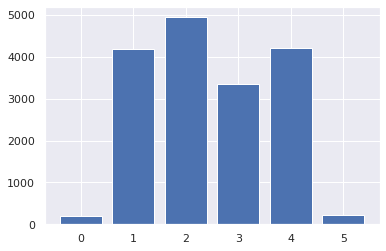

In [99]:
for i in range(len(fs.scores_)):
    print(f'Feature {X_train_numerical.columns[i]}: {fs.scores_[i]}')
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [100]:
# Most important feature: backers
# Second most important feature: usd_pledged_real

------

------

## Build a model with logistic regression

Use l2 penalty and search for optimal C in np.logspace(-2, 4, 7).

In [101]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [102]:
seed = 42

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

clf = LogisticRegression(penalty='l2', random_state=seed, max_iter=1000)

grid = {
    'C': np.logspace(-2, 4, 7)
}

log_gs = GridSearchCV(clf, param_grid=grid, cv=cv, scoring='accuracy', n_jobs=-1)
log_gs.fit(X_train, y_train['state'].values.astype(int))

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [103]:
log_gs.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Q4.2 What is an optimal C for l2 regularization?

In [104]:
# Optimal C is the biggest value among offered logspace: C = 10

### Q4.3 What is the accuracy for this params?

#### Train accuracy

In [105]:
all_splits_res = []
for i in range(5):
    split = f'split{i}_test_score'
    split_res = log_gs.cv_results_[split]
    all_splits_res.append(split_res)

In [106]:
np.array(all_splits_res).mean(axis=0)

array([0.77751329, 0.7940238 , 0.80988942, 0.82992488, 0.81233392,
       0.82967165, 0.81107453])

In [107]:
pd.DataFrame.from_dict({'C': np.logspace(-2, 4, 7), 'accuracy': np.array(all_splits_res).mean(axis=0)})

,C,accuracy
0,0.01,0.777513
1,0.10,0.794024
2,1.00,0.809889
3,10.00,0.829925
4,100.00,0.812334
5,1000.00,0.829672
6,10000.00,0.811075


#### Test accuracy

In [108]:
X_test_numerical = X_test.select_dtypes(exclude='object')
y_test_pred = log_gs.best_estimator_.predict(X_test_numerical)

In [109]:
accuracy_score(y_test['state'].values.astype(int), y_test_pred)

0.8191075576684134

### Q4.4 What is the two most important features by logistic regression estimation?

In [110]:
logreg_coef_df = pd.DataFrame.from_dict({'feature': X_train.columns.tolist(), 'weight': map(abs, log_gs.best_estimator_.coef_.tolist()[0])})

In [111]:
logreg_coef_df.sort_values(by='weight', ascending=False)

,feature,weight
3,goal,34.222307
5,backers,25.295515
7,usd_pledged_real,3.428832
4,pledged,1.012750
6,usd pledged,0.537413
2,currency,0.027196
9,duration_days,0.020706
1,main_category,0.006561
10,region,0.000701
0,category,0.000618


In [112]:
# Goal, backers

### Q4.5 Build roc curve and calculate roc-auc score. What is the roc-auc score?

#### Lets compute roc auc 

In [113]:
from sklearn.metrics import roc_auc_score, roc_curve

In [114]:
y_test_pred = log_gs.best_estimator_.predict_proba(X_test)

In [115]:
auc = roc_auc_score(y_test['state'].values.astype(int), y_test_pred[:,1])

In [116]:
auc

0.9309596667203239

In [117]:
fpr, tpr, thresholds = roc_curve(y_test['state'].values.astype(int), y_test_pred[:,1])

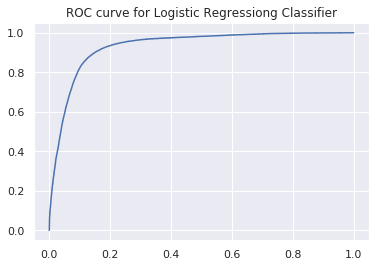

In [118]:
plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Logistic Regressiong Classifier')
plt.show()


------

------

## Build a random forest model
Use random state 42, maximum depth from 2 to 15, and number of estimators in `[10, 20, 50, 100, 200]`

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
seed = 42

# cv = KFold(n_splits=5, shuffle=True, random_state=seed)

clf = RandomForestClassifier(random_state=seed, n_jobs=-1)

grid = {
    'max_depth': range(2, 16, 1),
    'n_estimators': [10, 20, 50, 100, 200]
}

rf_gs = GridSearchCV(clf, param_grid=grid, cv=None, n_jobs=-1)
rf_gs.fit(X_train, y_train['state'].values.astype(int))

/home/artem/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                 

### Q4.6 What is an optimal depth and number of trees?

In [121]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [122]:
# Optimal parameters for RandomForest: max_depth=15, n_estimators=100

### Q4.7 What is the accuracy for this params?

In [123]:
y_test_pred = rf_gs.best_estimator_.predict(X_test)
accuracy_score(y_test['state'].values.astype(int), y_test_pred)

0.7490951326238453

### Q4.8 Build precision-recall curve. What is the precision for recall 0.5?

In [124]:
from sklearn.metrics import precision_recall_curve

In [125]:
precision, recall, thresholds = precision_recall_curve(y_test['state'].values.astype(int), y_test_pred)

In [128]:
recall

array([1.       , 0.3077067, 0.       ])

In [130]:
precision

array([0.360826  , 0.99012405, 1.        ])

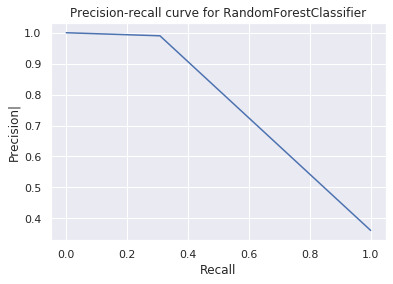

In [131]:
plt.plot(recall, precision)
plt.title('Precision-recall curve for RandomForestClassifier')
plt.xlabel('Recall')
plt.ylabel('Precision|')
plt.show()

### Q4.9 What is the two most important features by random forest?

In [132]:
rf_coef_df = pd.DataFrame.from_dict({'feature': X_train.columns.tolist(), 
                                     'weight': rf_gs.best_estimator_.feature_importances_})

In [133]:
rf_coef_df.sort_values(by='weight', ascending=False)

,feature,weight
3,goal,0.304498
7,usd_pledged_real,0.219003
4,pledged,0.187100
5,backers,0.182526
6,usd pledged,0.077103
9,duration_days,0.010076
1,main_category,0.006218
8,year,0.005205
0,category,0.004344
2,currency,0.002758


In [134]:
# 'goal' and 'usd_pledged_real'

------

------

# Build the stronger model

In [135]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

df.dropna(axis=0, inplace=True)
df[['state']] = df[['state']].replace('failed', 0)
df[['state']] = df[['state']].replace('canceled', 0)
df[['state']] = df[['state']].replace('successful', 1)
df.drop( df[ df['state'] == 'undefined' ].index, inplace=True)
df.drop( df[ df['state'] == 'live' ].index, inplace=True)
df.drop( df[ df['state'] == 'suspended' ].index, inplace=True)
df['launched'] = pd.to_datetime(df['launched'])
df['year'] = df.launched.dt.year
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = df['deadline'] - df['launched']
df['duration_days'] = df['duration_days'].astype('timedelta64[D]')
df['region'] = df[['country']].copy()

df['region'] = df[['region']].replace('GB', 'Europe')
df['region'] = df[['region']].replace('US', 'America')
df['region'] = df[['region']].replace('CA', 'America')
df['region'] = df[['region']].replace('AU', 'Oceania')
df['region'] = df[['region']].replace('NO', 'Europe')
df['region'] = df[['region']].replace('IT', 'Asia')
df['region'] = df[['region']].replace('DE', 'Europe')
df['region'] = df[['region']].replace('IE', 'Europe')
df['region'] = df[['region']].replace('MX', 'America')
df['region'] = df[['region']].replace('ES', 'Europe')
df['region'] = df[['region']].replace('SE', 'Europe')
df['region'] = df[['region']].replace('FR', 'Europe')
df['region'] = df[['region']].replace('NL', 'Europe')
df['region'] = df[['region']].replace('NZ', 'Oceania')
df['region'] = df[['region']].replace('CH', 'Europe')
df['region'] = df[['region']].replace('AT', 'Europe')
df['region'] = df[['region']].replace('BE', 'Europe')
df['region'] = df[['region']].replace('DK', 'Asia')
df['region'] = df[['region']].replace('HK', 'Asia')
df['region'] = df[['region']].replace('LU', 'Europe')
df['region'] = df[['region']].replace('SG', 'Asia')
df['region'] = df[['region']].replace('JP', 'Asia')

df['name_length'] = df['name'].str.len()

In [136]:
# Also, features 'pledged' and 'goal' are the week ones, because they show pledged in local currency, whereas we need in same currency (USD)
# besides that I figured out, that column 'usd pledged' is inconsistent with 'usd_pledged_real', 
# thus it's better to use the single data source 'usd_pledged_real' and 'usd_goal_real'

In [137]:
columns_to_drop = ['name', 'deadline', 'goal', 'launched', 'pledged', 'usd pledged', 'country']

In [138]:
df = df.drop(columns=columns_to_drop)

### Q5.1 Generate two (or more) meaningfull features

In [139]:
# Additional features:
# mean_main_category_goal
# mean_category_goal
# diff_mean_category_goal
# diff_mean_main_category_goal

In [140]:
t2 = df.groupby("main_category").agg({"usd_goal_real" : "mean", "category" : "sum"})
t2 = t2.reset_index().rename(columns={"usd_goal_real" : "mean_main_category_goal", "category" : "main_category_count"})

t1 = df.groupby("category").agg({"usd_goal_real" : "mean", "main_category" : "sum"})
t1 = t1.reset_index().rename(columns={"usd_goal_real" : "mean_category_goal", "main_category" : "category_count"})

df = df.merge(t1, on = "category")
df = df.merge(t2, on = "main_category")

df["diff_mean_category_goal"] = df["mean_category_goal"] - df["usd_goal_real"]
df["diff_mean_main_category_goal"] = df["mean_main_category_goal"] - df["usd_goal_real"]

df = df.drop(columns = ['main_category_count', 'category_count'])

In [141]:
# More features

df['diff_mean_category_goal_minus_pledged'] = df["mean_category_goal"] - df["usd_pledged_real"]
df['diff_mean_main_category_goal_minus_pledged'] = df["mean_main_category_goal"] - df["usd_pledged_real"]

In [142]:
cat_features = ['category', 'main_category', 'currency', 'region']

encoder = LabelEncoder()

df[cat_features] = df[cat_features].apply(encoder.fit_transform)

In [143]:
# week?

In [144]:
X = df.drop('state', axis=1, inplace=False)
Y = df[['state']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [145]:
df

,category,main_category,currency,state,backers,usd_pledged_real,usd_goal_real,year,duration_days,region,name_length,mean_category_goal,mean_main_category_goal,diff_mean_category_goal,diff_mean_main_category_goal,diff_mean_category_goal_minus_pledged,diff_mean_main_category_goal_minus_pledged
0,108,12,5,0,0,0.00,1533.95,2015,58.0,2,31,5213.996468,22605.780995,3680.046468,21071.830995,5213.996468,22605.780995
1,108,12,5,0,1,30.30,6060.97,2013,29.0,2,50,5213.996468,22605.780995,-846.973532,16544.810995,5183.696468,22575.480995
2,108,12,13,0,6,325.00,2000.00,2015,29.0,0,16,5213.996468,22605.780995,3213.996468,20605.780995,4888.996468,22280.780995
3,108,12,13,0,2,101.00,10000.00,2014,29.0,0,52,5213.996468,22605.780995,-4786.003532,12605.780995,5112.996468,22504.780995
4,108,12,1,0,3,41.66,757.52,2015,29.0,0,17,5213.996468,22605.780995,4456.476468,21848.260995,5172.336468,22564.120995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370214,122,3,13,1,31,3545.00,3000.00,2014,29.0,0,19,11802.966957,9408.592117,8802.966957,6408.592117,8257.966957,5863.592117
370215,122,3,1,0,6,45.50,446030.33,2014,59.0,0,5,11802.966957,9408.592117,-434227.363043,-436621.737883,11757.466957,9363.092117
370216,122,3,13,1,75,3010.00,3000.00,2017,30.0,0,17,11802.966957,9408.592117,8802.966957,6408.592117,8792.966957,6398.592117
370217,122,3,8,0,10,133.37,20349.80,2017,24.0,0,20,11802.966957,9408.592117,-8546.833043,-10941.207883,11669.596957,9275.222117


In [146]:
features_to_scale = ['backers',
                     'usd_pledged_real', 
                     'usd_goal_real', 
                     'mean_category_goal', 
                     'mean_main_category_goal', 
                     'diff_mean_category_goal',
                     'diff_mean_main_category_goal',
                     'diff_mean_category_goal_minus_pledged',
                     'diff_mean_main_category_goal_minus_pledged']

In [147]:
X_train[features_to_scale] = StandardScaler().fit_transform(X_train[features_to_scale])

/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/artem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [148]:
X_test[features_to_scale] = StandardScaler().fit_transform(X_test[features_to_scale])

/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/artem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Q5.2 Train an xgboost, that's beat random forest

In [149]:
import xgboost as xgb

In [150]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=15, n_jobs=-1)

In [151]:
xgb_model.fit(X_train, y_train['state'].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
xgb_pred = xgb_model.predict(X_test)

In [153]:
accuracy_score(y_test['state'].values.astype(int), xgb_pred.astype(int))

0.9129706660904328

In [154]:
roc_auc_score(y_test['state'].values.astype(int), xgb_pred.astype(int))

0.9269211007275252

In [155]:
precision, recall, thresholds = precision_recall_curve(y_test['state'].values.astype(int), xgb_pred.astype(int))

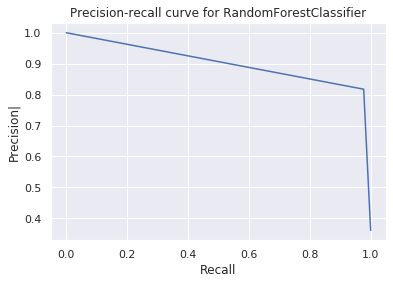

In [156]:
plt.plot(recall, precision)
plt.title('Precision-recall curve for RandomForestClassifier')
plt.xlabel('Recall')
plt.ylabel('Precision|')
plt.show()